#### Preliminary Testing - Phase 1 - Zero Shot on VQA and VLM

This notebook explores the following:

- Mounts Google Drive to enable model inference on Google Colab, removing the dependency on local resources

- Implements a basic frame sampling method for initial testing purposes

- Performs zero-shot inference on sampled frames from a single video using the llava-hf/LLaVA-NeXT-Video-7B-hf Vision-Language Model (VLM)

- Attempts zero-shot inference on the same frames using the MiniCPM-Llama3-V-2_5-int4 Visual Question Answering (VQA) model

In [ ]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

Torch version: 2.6.0+cu124
CUDA available: True
CUDA device count: 1
CUDA device name: Tesla T4


In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [ ]:
from transformers import BitsAndBytesConfig, LlavaNextVideoForConditionalGeneration, LlavaNextVideoProcessor
import torch

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

processor = LlavaNextVideoProcessor.from_pretrained("llava-hf/LLaVA-NeXT-Video-7B-hf")
model = LlavaNextVideoForConditionalGeneration.from_pretrained(
    "llava-hf/LLaVA-NeXT-Video-7B-hf",
    quantization_config=quantization_config,
    # Use device_map to explicitly place the model on the CPU
    device_map='auto'
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
import av
import numpy as np

def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.

    Args:
        container (av.container.input.InputContainer): PyAV container.
        indices (List[int]): List of frame indices to decode.

    Returns:
        np.ndarray: np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/task2"

Cric2.MP4  Cric3.MP4  Cric5.MP4  Cric6.MP4  frames


In [ ]:
# video_path = "My Drive/task2/Cric6.mp4"
# video_path = "/content/drive/My Drive/task2/Cric6.mp4"  # Regular path
# OR
# video_path = "/content/drive/My Drive/task2/Cric6.mp4"  # If using shell commands
# OR
video_path = "/content/drive/My Drive/task2/Cric6.MP4"  # Alternative

In [ ]:
questions = ["What limb is injured?", "Is the patient intubated?", "Where is the catheter inserted?", "Is there bleeding?",
                   "Has the bleeding stopped?", "Is the patient moving?", "Is the patient breathing?", "Is there a tourniquet?",
                   "Is there a chest tube?", "Are the patient and instruments secured?", "If a limb is missing which one?",
                   "Is there mechanical ventilation?","What is the position of the injury?"]  # Add more if needed


In [ ]:
from huggingface_hub import hf_hub_download

# Download video from the hub
# video_path_1 = hf_hub_download(repo_id="raushan-testing-hf/videos-test", filename="sample_demo_1.mp4", repo_type="dataset")
# video_path_2 = hf_hub_download(repo_id="raushan-testing-hf/videos-test", filename="karate.mp4", repo_type="dataset")
container = av.open(video_path)

# sample uniformly 8 frames from the video (we can sample more for longer videos)
total_frames = container.streams.video[0].frames
indices = np.arange(0, total_frames, total_frames / 5).astype(int)
clip_baby = read_video_pyav(container, indices)

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video = clip_baby

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=100)
HTML(anim.to_html5_video())

In [ ]:
# Define multiple questions

questions = [
    "What limb is injured?",
    "Is the patient intubated?",
    "Where is the catheter inserted?",
    "Is there bleeding?",
    "Has the bleeding stopped?",
    "Is the patient moving?",
    "Is the patient breathing?",
    "Is there a tourniquet?",
    "Is there a chest tube?",
    "Are the patient and instruments secured?",
    "If a limb is missing which one?",
    "Is there mechanical ventilation?",
    "What is the position of the injury?"
]



In [ ]:
# Store all responses
responses = []

for question in questions:
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": question},
                {"type": "video"},
            ],
        }
    ]

    # Apply chat template for each question
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

    # Process input for each question separately
    inputs = processor([prompt], videos=[clip_baby], padding=True, return_tensors="pt").to(model.device)

    # Generate response
    generate_kwargs = {"max_new_tokens": 4096, "do_sample": True, "top_p": 0.9}
    output = model.generate(**inputs, **generate_kwargs)

    # Decode response
    response_text = processor.batch_decode(output, skip_special_tokens=True)[0]
    responses.append((question, response_text))



Q: What limb is injured?
A: USER: 
What limb is injured? ASSISTANT: The image you've provided shows a person performing a medical procedure, likely practicing in a medical training setting, given the mannequin. It appears that the lower right limb of the mannequin has been damaged, possibly through trauma or surgical intervention. The individual's hands can be seen working on this area, likely for an educational or training exercise in the context of medical training.

Q: Is the patient intubated?
A: USER: 
Is the patient intubated? ASSISTANT: The image you've provided shows a medical practitioner engaged in an intubation procedure. However, the details are somewhat obscured, and due to the angle and resolution, it's not possible to definitively confirm if the patient is intubated. Intubation typically involves passing a tube over the patient's head and into their airway to help maintain airway patency, but it's not possible to tell from this image whether the patient has been intubate

In [ ]:
# Print or store all responses
for q, r in responses:
    pp.pprint(f"Q: {q}\nA: {r}\n")


('Q: What limb is injured?\n'
 'A: USER: \n'
 "What limb is injured? ASSISTANT: The image you've provided shows a person "
 'performing a medical procedure, likely practicing in a medical training '
 'setting, given the mannequin. It appears that the lower right limb of the '
 'mannequin has been damaged, possibly through trauma or surgical '
 "intervention. The individual's hands can be seen working on this area, "
 'likely for an educational or training exercise in the context of medical '
 'training.\n')
('Q: Is the patient intubated?\n'
 'A: USER: \n'
 "Is the patient intubated? ASSISTANT: The image you've provided shows a "
 'medical practitioner engaged in an intubation procedure. However, the '
 "details are somewhat obscured, and due to the angle and resolution, it's not "
 'possible to definitively confirm if the patient is intubated. Intubation '
 "typically involves passing a tube over the patient's head and into their "
 "airway to help maintain airway patency, but it's not

### Per Image

In [ ]:
### Images - frames fluctuating - Saarang

import cv2
import os

# Set the path of the video file
video_path = "/content/drive/My Drive/task2/Cric6.MP4"
output_folder = "/content/drive/My Drive/task2/frames"  # Folder to save images

# Create output folder if it does not exist
os.makedirs(output_folder, exist_ok=True)

# Open the video file
cap = cv2.VideoCapture(video_path)

frame_skip = 14  # Extract every 10th frame
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % frame_skip == 0:  # Only save every 10th frame
        frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_filename, frame)
        print(f"✅ Saved frame {frame_count}")

    frame_count += 1
cap.release()
print(f"✅ Extracted {frame_count} frames and saved them in {output_folder}")


✅ Saved frame 0
✅ Saved frame 14
✅ Saved frame 28
✅ Saved frame 42
✅ Saved frame 56
✅ Extracted 58 frames and saved them in /content/drive/My Drive/task2/frames


In [ ]:
!ls "/content/drive/My Drive/task2/frames"

frame_0000.jpg	frame_0014.jpg	frame_0028.jpg	frame_0040.jpg	frame_0050.jpg
frame_0010.jpg	frame_0020.jpg	frame_0030.jpg	frame_0042.jpg	frame_0056.jpg


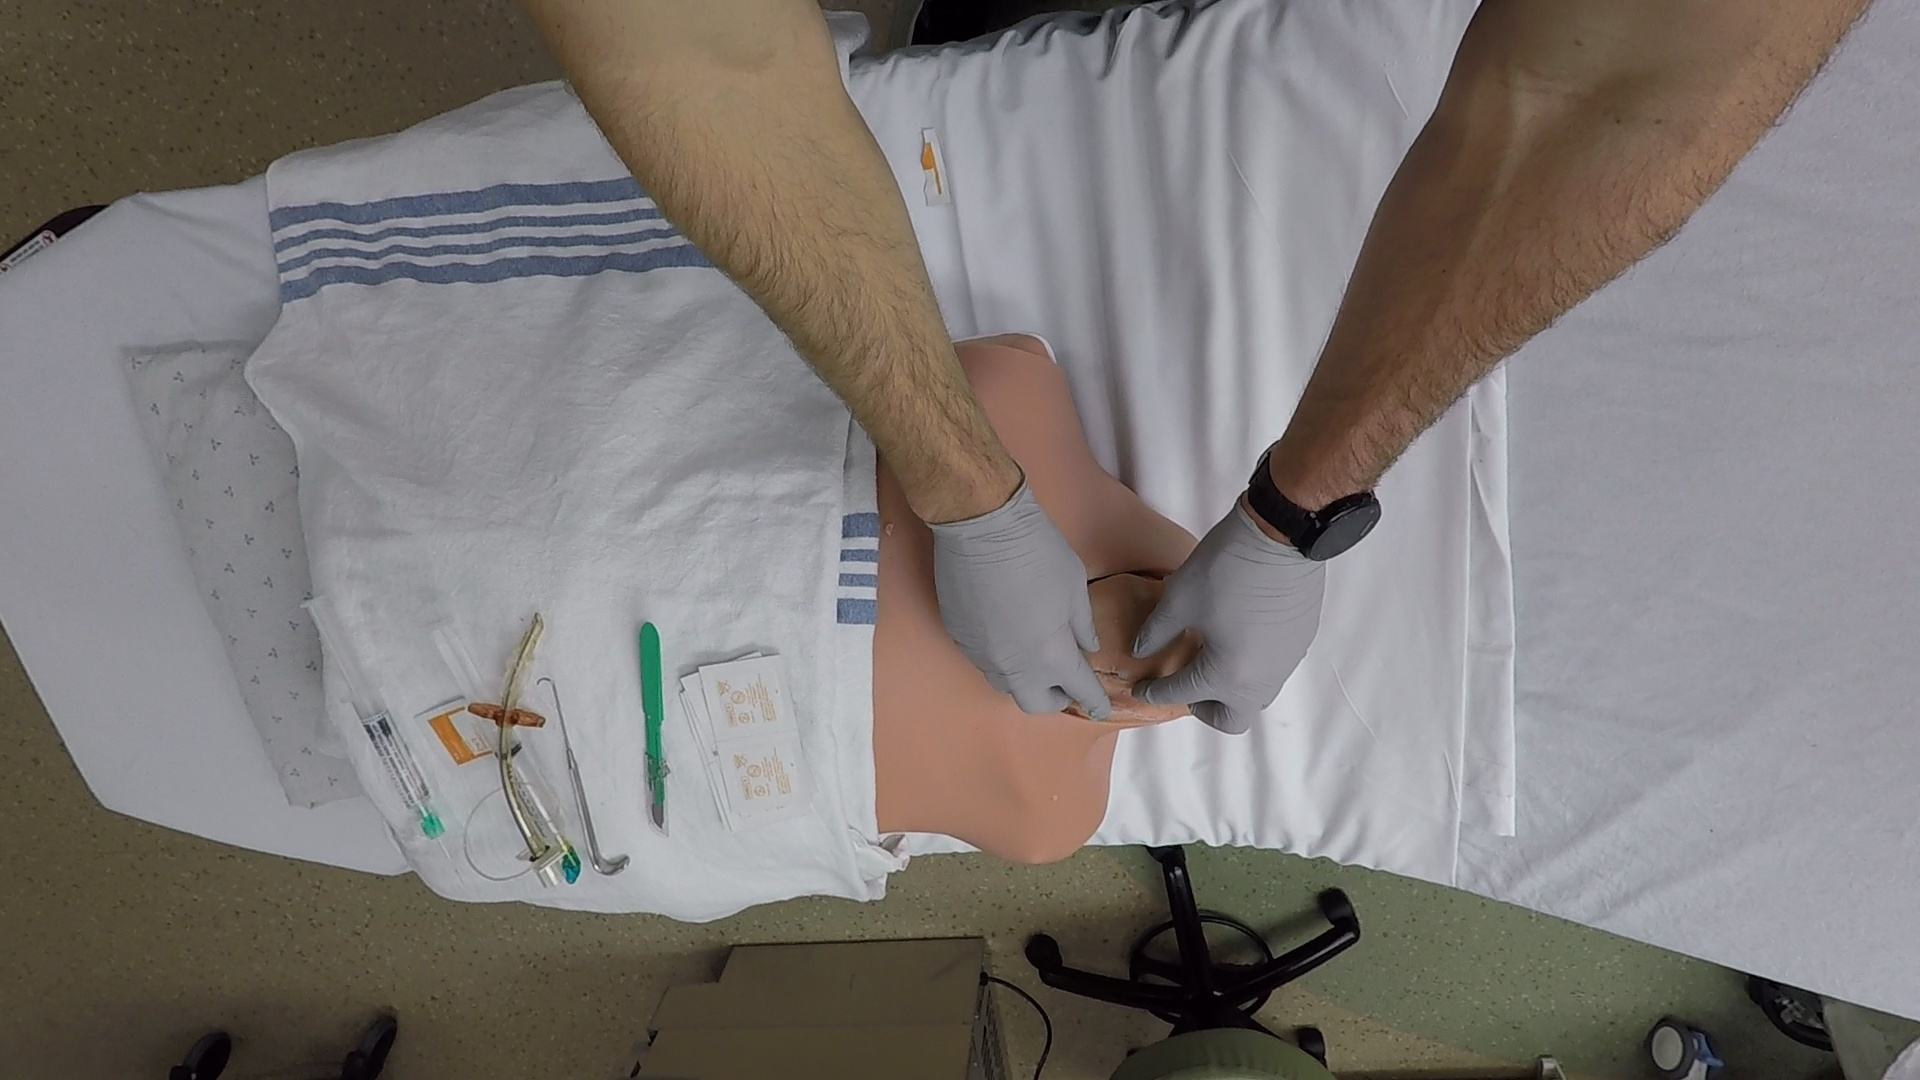

In [ ]:
from IPython.display import display
from PIL import Image

# Show the first extracted frame
img_path = "/content/drive/My Drive/task2/frames/frame_0050.jpg"
img = Image.open(img_path)
display(img)

In [ ]:
!pip install Pillow sentencepiece

In [ ]:
# test.py
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained('openbmb/MiniCPM-Llama3-V-2_5-int4', trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-Llama3-V-2_5-int4', trust_remote_code=True)
model.eval()

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

MiniCPMV(
  (llm): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(128256, 4096)
      (layers): ModuleList(
        (0-31): 32 x LlamaDecoderLayer(
          (self_attn): LlamaAttention(
            (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
            (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
            (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
            (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          )
          (mlp): LlamaMLP(
            (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
            (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
            (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
          (post_attention_layernorm): LlamaRMSNorm((4096,),

In [ ]:
import os
frames_folder = "/content/drive/My Drive/task2/frames"  # Update if needed


# They have never seem these images - ecocentric
#  Modify prompts - more context - mannequin
#      We offer the first egocentric view dataset of life-saving intervention (LSI) procedures with detailed annotations by medical professionals
#      Provide options



# Get all images in the folder (supports JPG, PNG, and JPEG)
image_files = sorted([
    f for f in os.listdir(frames_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])

# Process each image
for img_name in image_files:
    img_path = os.path.join(frames_folder, img_name)
    image = Image.open(img_path).convert("RGB")
    display(Image.open(img_path))
    for question in questions:
      msgs = [{'role': 'user', 'content': question}]

      res = model.chat(
          image=image,
          msgs=msgs,
          tokenizer=tokenizer,
          sampling=True, # if sampling=False, beam_search will be used by default
          temperature=0.7,
          system_prompt='Keep your response limited to a sentence, short and simple. If it is not possible to determine based on the image, then simply say NA.'
      )
      pp.pprint(res)
